In [1]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Normal
from stable_baselines3.common.noise import OrnsteinUhlenbeckActionNoise
from collections import deque
import matplotlib.pyplot as plt
from torchinfo import summary

In [2]:
env = gym.make('BipedalWalker-v3')
print(env.action_space.sample(), len(env.action_space.sample()))
print(env.observation_space.sample(), len(env.observation_space.sample()))

[ 0.7307754  -0.17209464 -0.2732674  -0.2866211 ] 4
[ 2.0414395  -0.2208009   1.9522104   1.0644985   1.9648093   3.6555429
 -1.6649635   4.1972146   3.3268633   1.0310632  -1.1809065   1.0909851
 -2.5090435   3.2501094   0.31599852 -0.1294532   0.71002585 -0.0340201
 -0.84592485  0.3155809   0.10380564  0.3195452   0.82528424  0.587091  ] 24


In [2]:
class Actor(nn.Module) :
    def __init__(self, input_size, hidden_size, n_actions, lr, device=torch.device('cpu')):
        super(Actor, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_output = n_actions
        self.lr = lr
        self.device = device

        self.fc1 = nn.Linear(self.input_size, self.hidden_size)
        self.fc2 = nn.Linear(self.hidden_size, self.hidden_size)
        self.mean_fc3 = nn.Linear(self.hidden_size, self.n_output)
        self.log_std_fc3 = nn.Linear(self.hidden_size, self.n_output)

        self.optimizer = optim.RMSprop(self.parameters(), lr=self.lr)
        self.noise = OrnsteinUhlenbeckActionNoise(mean=np.zeros(n_actions), sigma=0.28)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))

        mean = self.mean_fc3(x)

        log_std = self.log_std_fc3(x)

        return mean, torch.clamp(log_std, -20, 2)
    
    def act(self, state, explore=False):
        mean, log_std = self.forward(state)

        gaussian = Normal(0, 1)
        z = gaussian.sample().to(self.device)
        std = log_std.exp()

        action = torch.tanh(mean + std*z)
        log_prob = Normal(mean, std).log_prob(mean + std*z)

        if explore and np.random.rand() < 7e-1:
            #   m = mean.detach().numpy()
            #   s = std.detach().numpy()
            #   self.noise = OrnsteinUhlenbeckActionNoise(mean=m, sigma=s)
            noise = torch.from_numpy(self.noise())
            #print('\taction: ', action)
            action += noise
            #print('\tnoisy action: ', action)
            #print('\n')
            log_prob += noise

        return action, log_prob
    
actor = Actor(24,48,4, 1e-4)
summary(actor,
        input_size=(1,24),
        col_width=20,
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        row_settings=['var_names'],
        verbose=0)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
Actor (Actor)                            [1, 24]              [1, 4]               --                   True
├─Linear (fc1)                           [1, 24]              [1, 48]              1,200                True
├─Linear (fc2)                           [1, 48]              [1, 48]              2,352                True
├─Linear (mean_fc3)                      [1, 48]              [1, 4]               196                  True
├─Linear (log_std_fc3)                   [1, 48]              [1, 4]               196                  True
Total params: 3,944
Trainable params: 3,944
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.02
Estimated Total Size (MB): 0.02

### Critic

In [3]:
class Critic(nn.Module) :
    def __init__(self, input_size, hidden_size, lr, device=torch.device('cpu')):
        super(Critic, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.lr = lr
        self.device = device

        self.fc1 = nn.Linear(self.input_size, self.hidden_size)
        self.fc2 = nn.Linear(self.hidden_size, self.hidden_size)
        self.fc3 = nn.Linear(self.hidden_size, 1)

        self.optimizer = optim.RMSprop(self.parameters(), lr=self.lr)
        self.criterion = nn.MSELoss()

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))

        return self.fc3(x)
critic = Critic(24,32,1, 1e-4)
summary(critic,
        input_size=(1,24),
        col_width=20,
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        row_settings=['var_names'],
        verbose=0)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
Critic (Critic)                          [1, 24]              [1, 1]               --                   True
├─Linear (fc1)                           [1, 24]              [1, 32]              800                  True
├─Linear (fc2)                           [1, 32]              [1, 32]              1,056                True
├─Linear (fc3)                           [1, 32]              [1, 1]               33                   True
Total params: 1,889
Trainable params: 1,889
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.01

### Wrapper

In [4]:
# this wrapper normalize the actions passed to env.step()
class NormalizedActions(gym.ActionWrapper):
    def action(self, action):
        low  = self.action_space.low
        high = self.action_space.high
        
        action = low + (action + 1.0) * 0.5 * (high - low)
        action = np.clip(action, low, high)
        
        return action

    def reverse_action(self, action):
        low  = self.action_space.low
        high = self.action_space.high
        
        action = 2 * (action - low) / (high - low) - 1
        action = np.clip(action, low, high)
        
        return action

### A2C

In [7]:
class ActorCritic(nn.Module):
    def __init__(self, actor, critic, device=torch.device('cpu')):
        super(ActorCritic, self).__init__()
        self.actor = actor.to(device)
        self.critic = critic.to(device)
        self.device = device

    def save(self, model_name):
        torch.save(self.state_dict(), model_name + '.pt')

    def load(self, model_name):
        self.load_state_dict(torch.load(model_name + '.pt', map_location=self.device))

    def to(self, device):
        ret = super().to(device)
        ret.device = device
        return ret
    
    def train(self, gamma=0.9, num_episodes=10000):

        E = NormalizedActions(gym.make('BipedalWalker-v3'))
        act_losses = deque()
        crt_losses = deque()
        scores = deque()

        for ep in range(num_episodes):

            R = []
            Prob = []
            Values = []
            Delta = []
            state = torch.from_numpy(E.reset()[0])
            done = False
            count = 0

            while not done:
                
                action, prob = self.actor.act(state, explore=True)
                Prob.append(prob)
                #print('Action: ', action)
                #   print('Prob: ',prob)

                next_state, reward, term, trunc, _ = E.step(action.detach().numpy())
                next_state = torch.from_numpy(next_state)

                value_state = self.critic.forward(state)
                # print(value_state)
                Values.append(value_state)
                value_next_state = self.critic.forward(next_state)
                
                td_target = reward + gamma*value_next_state
                td_error = td_target - value_state
                #print(td_error)
                Delta.append(td_error)
                done = term or trunc
                count += 1
                R.append(reward)

            Prob = torch.stack(Prob).squeeze()
            Values = torch.stack(Values).squeeze()
            Delta = torch.stack(Delta).squeeze()

            act_loss = (- Prob.T @ Delta.detach()).mean()
            crt_loss = self.critic.criterion(Values, Delta)
            # print(act_loss)
            self.actor.optimizer.zero_grad()
            act_loss.backward()
            #torch.nn.utils.clip_grad_norm_(self.actor.parameters(), 0.5)
            self.actor.optimizer.step()

            self.critic.optimizer.zero_grad()
            crt_loss.backward()
            #torch.nn.utils.clip_grad_norm_(self.critic.parameters(), 0.5)
            self.critic.optimizer.step()

            if ep % 100 == 0:
                print(ep, act_loss, crt_loss, '\n')

            act_losses.append(act_loss.item())
            crt_losses.append(crt_loss.item())
            scores.append(np.mean(R))

        
        torch.save({
            'model_state_dict': self.state_dict(),
            'actor': act_losses,
            'critic': crt_losses,
            'scores': scores,
            },'noise_bipedal.pt'
        )

        return act_losses, crt_losses, scores

In [60]:
a2c = ActorCritic(actor, critic)

act_losses, crt_losses, scores = a2c.train()

0 tensor(-207.8632, grad_fn=<MeanBackward0>) tensor(192.4796, grad_fn=<MseLossBackward0>) 

100 tensor(-364038.3125, grad_fn=<MeanBackward0>) tensor(43176768., grad_fn=<MseLossBackward0>) 

200 tensor(-9315238., grad_fn=<MeanBackward0>) tensor(59024108., grad_fn=<MseLossBackward0>) 

300 tensor(47267.3906, grad_fn=<MeanBackward0>) tensor(1710458.3750, grad_fn=<MseLossBackward0>) 

400 tensor(118900.5312, grad_fn=<MeanBackward0>) tensor(1641455.5000, grad_fn=<MseLossBackward0>) 

500 tensor(7141.4644, grad_fn=<MeanBackward0>) tensor(1333924.2500, grad_fn=<MseLossBackward0>) 

600 tensor(117787.0625, grad_fn=<MeanBackward0>) tensor(968780.8125, grad_fn=<MseLossBackward0>) 

700 tensor(18228.8359, grad_fn=<MeanBackward0>) tensor(538877.4375, grad_fn=<MseLossBackward0>) 

800 tensor(1310450.6250, grad_fn=<MeanBackward0>) tensor(542555.1875, grad_fn=<MseLossBackward0>) 

900 tensor(49333.3047, grad_fn=<MeanBackward0>) tensor(907946.0625, grad_fn=<MseLossBackward0>) 

1000 tensor(-113805.937

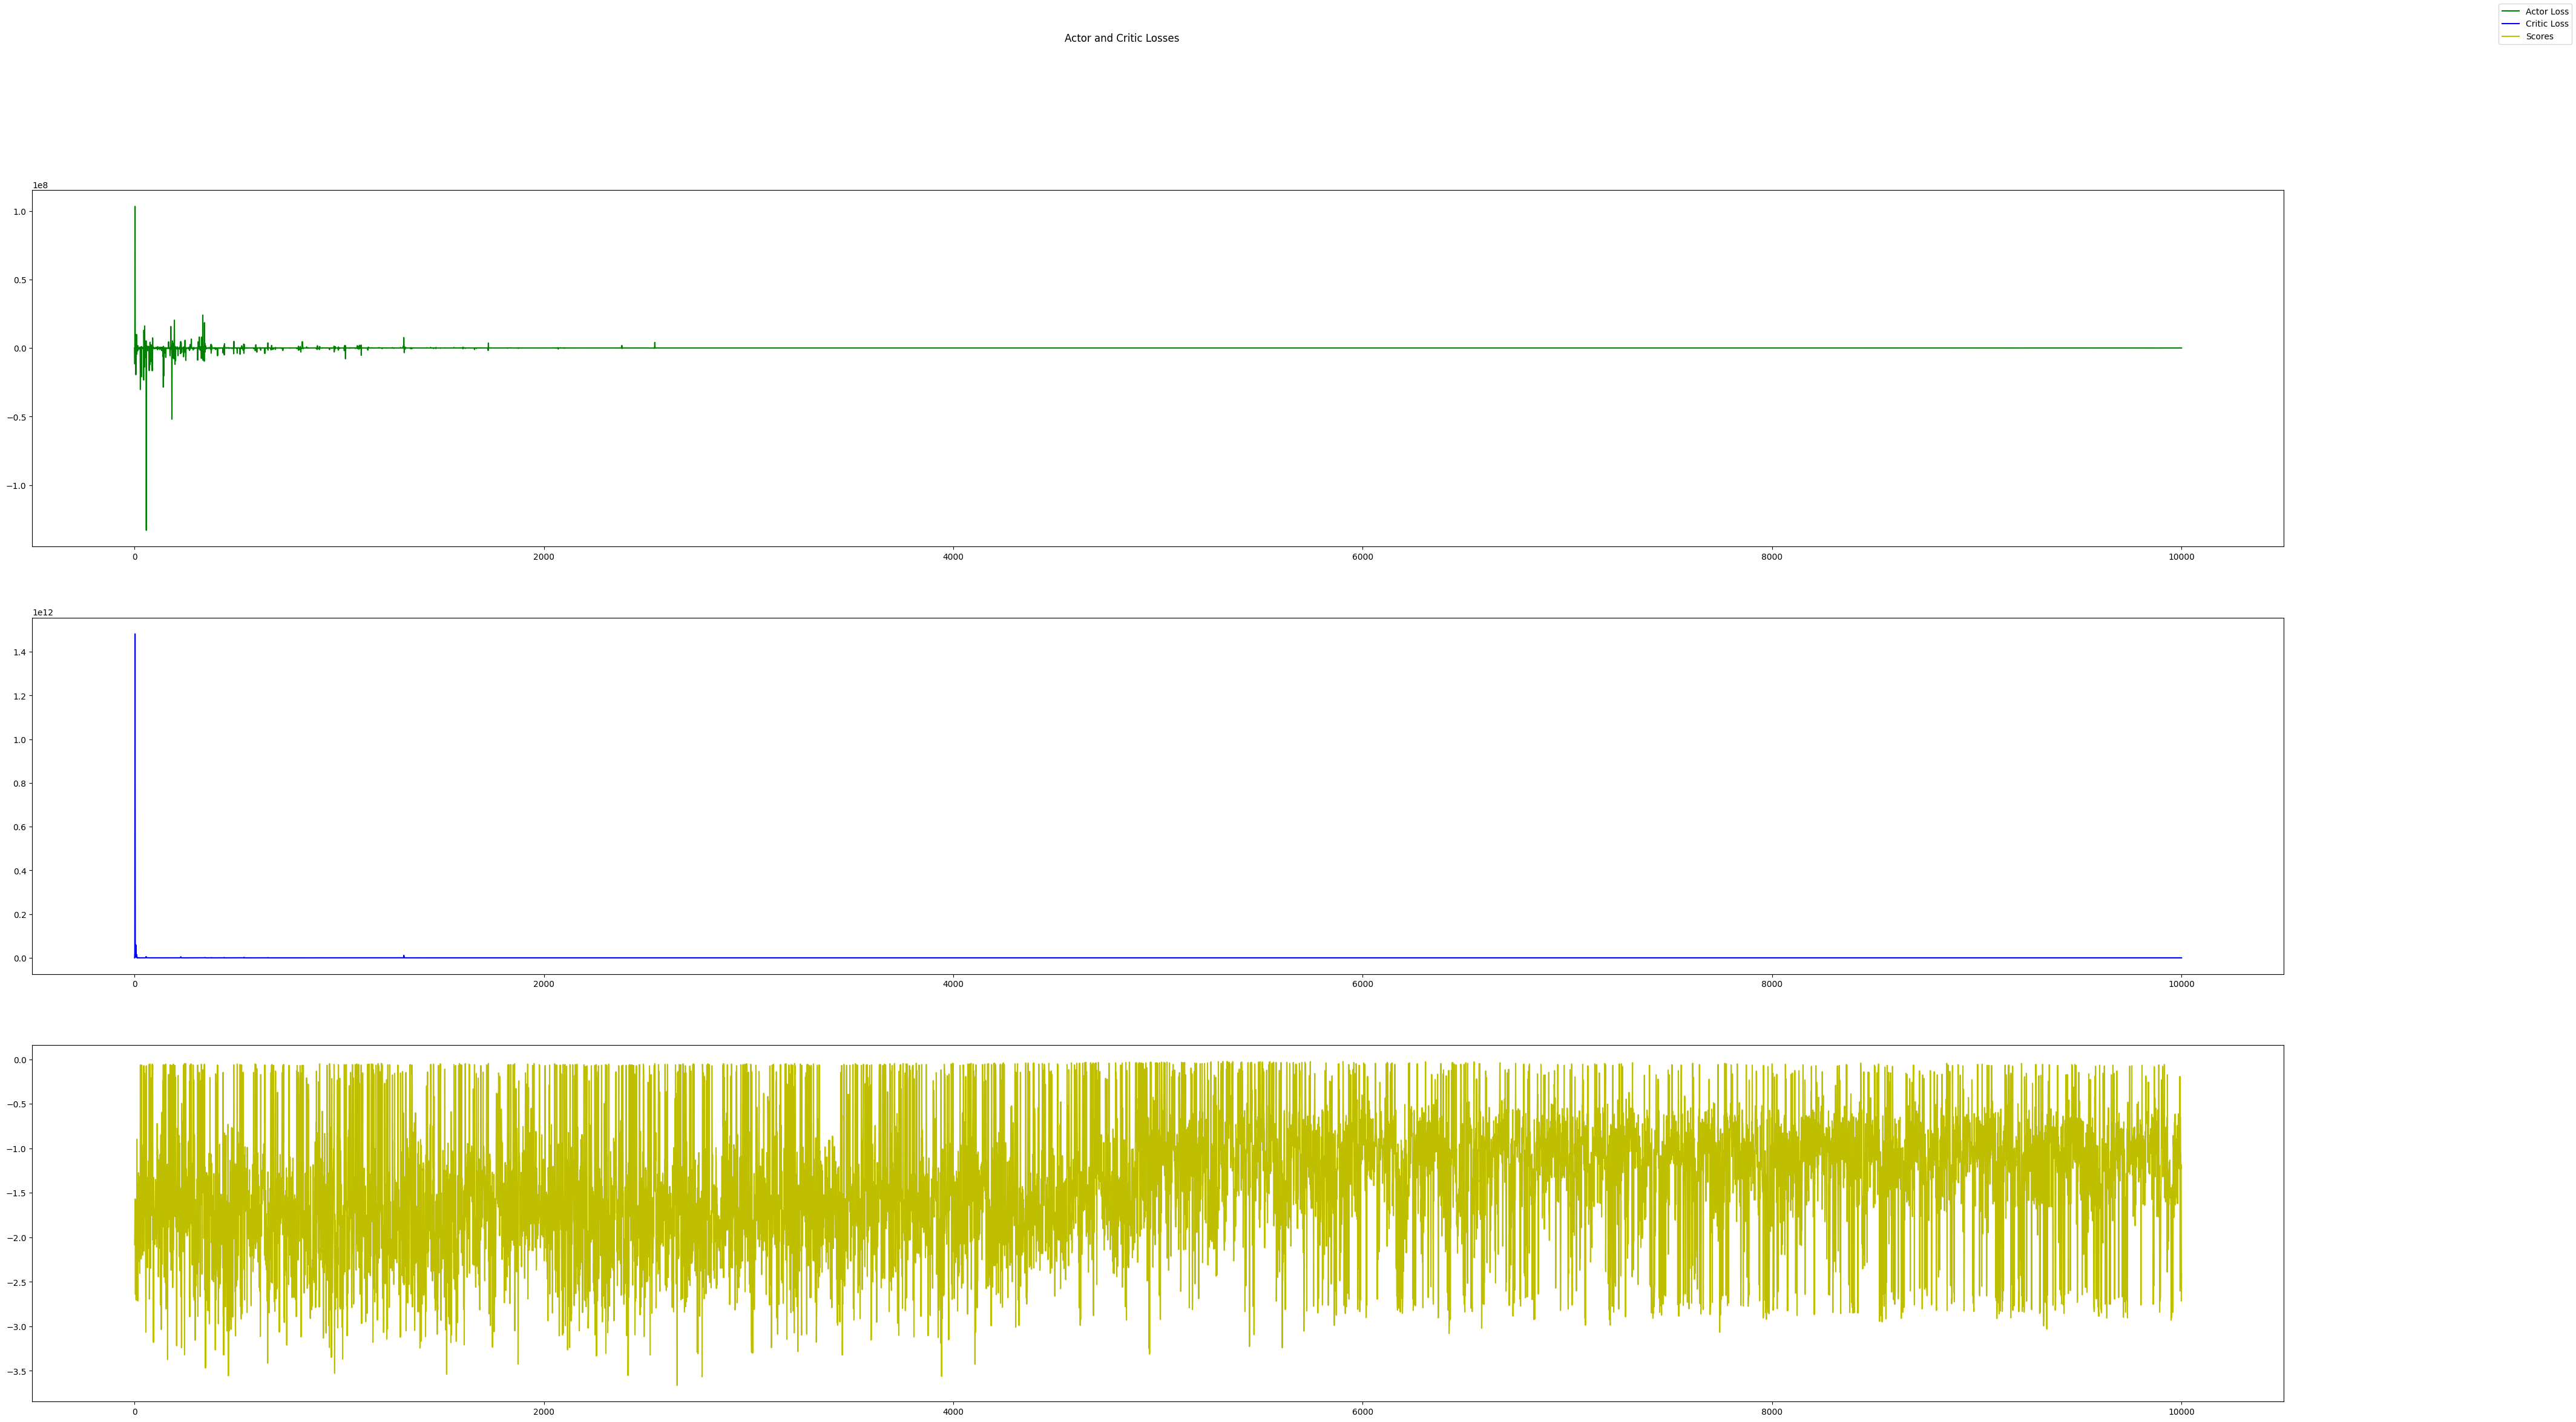

In [61]:
num_episodes = 10000
episodes = np.arange(1, num_episodes + 1)
fig, (ax1, ax2, ax3) = plt.subplots(3, 1)
fig.suptitle('Actor and Critic Losses')
ax1.plot(episodes, act_losses, 'g', label='Actor Loss')
ax2.plot(episodes, crt_losses, 'b', label='Critic Loss')
ax3.plot(episodes, scores, 'y', label='Scores')
fig.legend()
fig.set_figwidth(48)
fig.set_figheight(26)

In [5]:
from gym.wrappers import RecordVideo

In [14]:
def Evaluate(agent, n_eval_episodes, model_name):
    rewards = []
    #check = torch.load(model_name+'.pt')
    agent.load(model_name)
    #agent.load_state_dict(check['model_state_dict'])

    val_env = NormalizedActions(gym.make(
            id='BipedalWalker-v3',
            render_mode='rgb_array',          
        ))

    val_env = RecordVideo(val_env, 'video', episode_trigger=lambda x: x==2, video_length=0)
    for n_episode in range(n_eval_episodes):
        episode_rewards = 0
        obs = val_env.reset()[0]
        val_env.start_video_recorder()
        done = False
        count = 0
        while not done:
            count += 1
            action, _ = agent.actor.act(torch.from_numpy(obs))
            obs_next, rew, terminated, truncated, _ = val_env.step(action.detach().numpy())
            #print(obs_next[0])
            done = terminated or truncated
            #val_env.render()
            episode_rewards += rew
            obs = obs_next
            if count == 200:
                done = True # exit when you are stuck in some position without actually falling
            if done:
                val_env.close_video_recorder()
        print('Reward episode %d: %d' %(n_episode, episode_rewards))

        rewards.append(episode_rewards)

    print('Mean Reward: ', np.mean(rewards))
    val_env.close()
# 'final_bipedal' --> stuck version : average (-41) with a min (-16)  10k epochs
# 'noise_bipedal' --> fixed noise version : average () with a min ()    k epochs
c = Critic(24,64,1, 1e-4)
a = Actor(24,48,4, 1e-4)
ac = ActorCritic(a,c)
Evaluate(ac, 4, 'final_bipedal')

/home/brock/.local/lib/python3.10/site-packages/gym/wrappers/record_video.py:75: UserWarning: WARN: Overwriting existing videos at /home/brock/Desktop/Walking-Humanoid-RL/video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
/home/brock/.local/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.is_vector_env to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.is_vector_env` for environment variables or `env.get_wrapper_attr('is_vector_env')` that will search the reminding wrappers.
  logger.warn(


Moviepy - Building video /home/brock/Desktop/Walking-Humanoid-RL/video/rl-video-episode-0.mp4.
Moviepy - Writing video /home/brock/Desktop/Walking-Humanoid-RL/video/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /home/brock/Desktop/Walking-Humanoid-RL/video/rl-video-episode-0.mp4
Reward episode 0: -16
Moviepy - Building video /home/brock/Desktop/Walking-Humanoid-RL/video/rl-video-episode-0.mp4.
Moviepy - Writing video /home/brock/Desktop/Walking-Humanoid-RL/video/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /home/brock/Desktop/Walking-Humanoid-RL/video/rl-video-episode-0.mp4
Reward episode 1: -16
Moviepy - Building video /home/brock/Desktop/Walking-Humanoid-RL/video/rl-video-episode-0.mp4.
Moviepy - Writing video /home/brock/Desktop/Walking-Humanoid-RL/video/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /home/brock/Desktop/Walking-Humanoid-RL/video/rl-video-episode-0.mp4
Reward episode 2: -115
Moviepy - Building video /home/brock/Desktop/Walking-Humanoid-RL/video/rl-video-episode-1.mp4.
Moviepy - Writing video /home/brock/Desktop/Walking-Humanoid-RL/video/rl-video-episode-1.mp4



Moviepy - Done !
Moviepy - video ready /home/brock/Desktop/Walking-Humanoid-RL/video/rl-video-episode-1.mp4
Reward episode 3: -16
Mean Reward:  -41.10224851550224


In [74]:

#check = torch.load('noise_bipedal.pt')
#act_losses = check['actor']
#crt_losses = check['critic']
#scores = check['scores']
#Evaluate(ac, 1)

Reward episode 0: -16
Mean Reward:  -16.407885888374103


In [1409]:
noise = OrnsteinUhlenbeckActionNoise(mean=np.zeros(4), sigma=0.25, dt=1e-3)

In [1896]:
print(noise.noise_prev)
print(noise())

[-0.45683813 -0.12213354 -0.040984    0.06115483]
[-0.4636411  -0.11899026 -0.05118574  0.05613625]


# Add some action noise for exploration
n_actions = env.action_space.shape[-1]
action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))
# Because we use parameter noise, we should use a MlpPolicy with layer normalization
model = TD3("MlpPolicy", env, action_noise=action_noise, verbose=0)
# Create the callback: check every 1000 steps
callback = SaveOnBestTrainingRewardCallback(check_freq=1000, log_dir=log_dir)
# Train the agent